# Analysis of classes from learn_ELGz.ipynb

In [9]:
import pickle
import numpy as np
import jplus
import get_3dhst as hst
from astropy.io import fits
import elgtools as elg
import MockJPLUS as mtools
import matplotlib
import matplotlib.pyplot as plt
import Read_Mocks as read



pred_file = 'classification'
pred_dict = pickle.load(open(pred_file))

pred = pred_dict['pred']
dcat = pred_dict['all']

sigmafile = 'sigma_curves.data'
sigmadict = pickle.load(open(sigmafile))



In [10]:
noii = len(np.where(np.asarray(pred) == 'OII')[0])
noiiihb = len(np.where(np.asarray(pred) == 'OIII+Hbeta')[0])
ncont = len(np.where(np.asarray(pred) == 'contaminant')[0])

print 'Number of\nOII emitters:%d\nOIII-HB emitters:%d\nContaminants:%d'%(
    noii,noiiihb,ncont)





Number of
OII emitters:15752
OIII-HB emitters:54054
Contaminants:15147


41.9235882537 43.4039084279
ntiles 484
full_circle [deg^2] 41252.9612494
frac_area: 0.0183965460179 area_survey [deg^2]: 2732083.2
Volume (Mpc^3): 306479333.537 306553480.536
[  9.78858824e-08   4.37758974e-07   1.40757645e-06   2.23500144e-06
   2.24450808e-06   1.69794311e-06   1.04462578e-06   6.22514537e-07
   3.37513147e-07   1.98472193e-07   1.38431542e-07   1.08216915e-07
   7.29598290e-08   4.61438475e-08   3.26286275e-08]


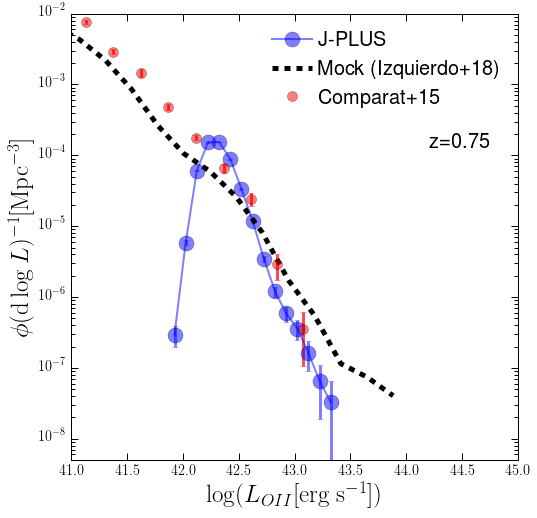

In [11]:
%matplotlib inline
from astropy.cosmology import Planck15

ld= Planck15.luminosity_distance(0.75).value

#compute LFs
mpc2cm= 3.08e24
ld *= mpc2cm
id_oii = np.asarray(pred) == 'OII'

gal_oii = jplus.tools.select_object(dcat,id_oii)

f_oii = gal_oii['F_j0660']

loii = f_oii * 4*np.pi*ld**2

min_oii = np.min(np.log10(loii))
max_oii = np.max(np.log10(loii))
lbin = 0.1
nbins = int(np.floor((max_oii-min_oii)/lbin+1))
print min_oii,max_oii
binarr = np.arange(nbins)*lbin + min_oii

phi, lbb = np.histogram(np.log10(loii),bins=nbins,range=[min_oii-lbin/2.,max_oii+lbin/2.])

depth = Planck15.comoving_distance(0.8) - Planck15.comoving_distance(0.74)
area_tile = (1.4*60)**2 #deg^2
ntiles = len(np.unique(dcat['tile_id']))
print 'ntiles %d'%ntiles
mask_factor = 0.8 #to be computed properly
area_survey = area_tile*ntiles*mask_factor*(Planck15.kpc_comoving_per_arcmin(0.77).value/(1e3))**2

full_circle = 4*np.pi*(360.0/(2*np.pi))**2  #~41,000 deg^2
frac_area = 1.4**2 * ntiles*mask_factor / full_circle
print 'full_circle [deg^2]',full_circle
print 'frac_area:',frac_area, 'area_survey [deg^2]:',area_tile*ntiles*mask_factor
volume = (Planck15.comoving_volume(0.8).value - Planck15.comoving_volume(0.74).value)*frac_area 
volume_old = area_survey * depth.value
print 'Volume (Mpc^3):',volume, volume_old

errs =np.sqrt(phi)/(volume * lbin)
print errs

plt.figure('LFOII',figsize=(8,8))
ax = plt.subplot(111)

ax.semilogy(binarr, phi/volume/lbin,'bo-',linewidth=2,markersize=15,label='J-PLUS',alpha=0.5)
ax.errorbar(binarr, phi/volume/lbin, yerr = errs, fmt='b,',alpha=0.5,elinewidth=3)
ax.set_ylabel(r'$\phi ({\rm d}\log L)^{-1}[{\rm Mpc^{-3}]$',fontsize=25)
ax.set_xlabel(r'$\log(L_{OII} [{\rm erg~s^{-1}}])$',fontsize=25)


fmockdata = 'data/z_0.7875'
fcomparatdata = 'data/z_0.7875_data'

mockphi = np.loadtxt(fmockdata)
dataphi = np.loadtxt(fcomparatdata)

ax.semilogy(mockphi[:,0],mockphi[:,1],'k--',linewidth=5,label='Mock (Izquierdo+18)')
ax.semilogy(dataphi[:,0],dataphi[:,1],'ro',markersize=10,label='Comparat+15',alpha=0.5)
ax.errorbar(dataphi[:,0],dataphi[:,1],yerr=[dataphi[:,5],dataphi[:,4]], fmt='r,',alpha=0.7,
            elinewidth=3)
ax.set_xlim([41,45])
ax.set_ylim([5e-9,1e-2])
ax.text(0.8,0.7,'z=0.75',transform=ax.transAxes,fontsize=20)
ax.legend(loc='upper right',fontsize=20)


In [27]:
# Perform completeness correction on that LF
import multiprocessing as mp
from scipy import interpolate

sigmadict.keys()
names_filters = ['uJAVA' , 'J0378', 'J0395', 'J0410', 'J0430', 'gSDSS',
                 'J0515', 'rSDSS', 'J0660', 'iSDSS', 'J0861', 'zSDSS']

suff = 'SDSS'
sdss_mw     = [3543, 4770, 6231, 7625, 9134]
alltiles = sigmadict['tiles']
ntiles = len(alltiles)

gcat = dcat # Use all objects in gcat to sample completeness
magrrange = [20,24] #Magnitude range in r band
nmags     = 20 #Sample each magnitude bin nmags times
nl = 10
noff = 1.0

nboff = np.linspace(-noff,0,nl)
ptile = 55
pgal = 234
DoPlots = False

from astropy.cosmology import Planck15
ld= Planck15.luminosity_distance(0.75).value

mpc2cm= 3.08e24
ld *= mpc2cm

nproc = 8  # number of parallel processes
i0 = 0  # file sub-volumes
i1 = ntiles
npp = int((i1-i0+1.0)/(nproc+0.0))

groupby = 'lum_line' #dm or lum_line

min_oii = 41.0 if groupby == 'lum_line' else -5.0
max_oii = 44.0 if groupby == 'lum_line' else 5.0
lbin    = 0.1     if groupby == 'lum_line' else 0.1

nbins = int(np.floor((max_oii-min_oii)/lbin+1))
print min_oii,max_oii
binarr = np.arange(nbins)*lbin + min_oii
comp_tile = np.zeros([ntiles,nbins]) - 100
comp_funcs = []
#for it in range(ntiles):
gj0660 = 2.0

for it in range(ntiles):
    
    tt = alltiles[it]
    sdata = sigmadict['sfunc'][it]    
    tsel = (gcat['tile_id'] == tt)
    gtile = jplus.tools.select_object(gcat,tsel)
    ng = len(gtile['tile_id'])
    if ng == 0:
        print tt
        comp_funcs.append([])
        continue
    sfunc = interpolate.interp1d(sdata[0], sdata[1], 
                                 fill_value = 'extrapolate')
    
    max_r = np.max(gtile['rSDSS'][:,0]) # This should roughly correspond to the SNR cut in each tile.
    if it < 10:
        print max_r
        
    magr_arr = np.tile(np.linspace(magrrange[0],np.max([max_r, 22.0]),nmags),nl)
    rbin = magr_arr[1] - magr_arr[0]

    test_gals = {}
    for mag in names_filters:
        test_gals[mag] = np.zeros(ng*nmags*nl)
    
    ik = 0 #counter
    for ig in range(ng): # Re-sampling each galaxy
        magr_ig = gtile['rSDSS'][ig,0]
        if ig == pgal and it == ptile and DoPlots:
            plt.figure('sample')
        for mag in names_filters:
            mf = gtile[mag][ig,0] + (magr_arr - magr_ig)
            mdelta = np.random.normal(0, gtile[mag][ig,1],nmags*nl)
            test_gals[mag][ik:ik+nmags*nl] = mf #+ mdelta
            if mag == 'J0660':
                for iil in range(nl):
                    test_gals[mag][ik+nmags*iil:ik+nmags*(iil+1)] += nboff[iil]
                    
                if ig ==0 and it ==0:
                    print 'mag_J0660:', gtile[mag][ig,0]
                    print 'magr_arr'
                    print magr_arr
                    print
                    print 'mf'
                    print mf
                    print
                    print 'mdelta (errors)'
                    print mdelta
                    print
                    print 'test_gals'
                    print  test_gals[mag][ik:ik+nmags*nl]
                    print 
                    print 'nboff tiled'
                    print np.tile(nboff,nmags)
                    
            if mag == 'rSDSS':        
                if ig ==0 and it ==0:
                    print 'mag_rSDSS:', gtile[mag][ig,0]
                    print 'magr_arr'
                    print magr_arr
                    print
                    print 'mf'
                    print mf
                    print
                    print 'mdelta (errors)'
                    print mdelta
                    print
                    print 'test_gals'
                    print  test_gals[mag][ik:ik+nmags*nl]
                    print 
                    print 'nboff tiled'
                    print np.tile(nboff,nmags)
                    

            
            
            if ig ==pgal and it == ptile and DoPlots:
                if 'SDSS' not in mag:
                    filt = jplus.tools.fetch_jplus_filter(mag, quiet=True)
                    ww = filt.avgwave()
                else:
                    filt = jplus.tools.fetch_sdss_filter(mag, quiet=True)
                    ww = [filt[0,filt[1,:].argmax()],filt[0,filt[1,:].argmax()]]
                    
                plt.plot([ww]*nmags,test_gals[mag][ik:ik+nmags],'.',color='red')
                plt.ylim([17,23])
        
        ik += nmags*nl
        
    # compute 3FM for all resampled galaxies in tile
    
    dm, fline, fcont = mtools.gen_3fm(test_gals['J0660'],  
                    test_gals['r'+suff], test_gals['g'+suff], 
                    Broad_NoLineName='g'+suff)
    test_gals['dm'] = dm
    test_gals['lum_line'] = np.log10(fline * 4*np.pi*ld**2) # All objects are assumed at z=0.75
    #print test_gals['lum_line'].min(), test_gals['lum_line'].max()
    # group by luminosity
    if it ==0:
        print 'i_tile, lum, completeness, rSDSS'
    for ibb in range(nbins):
        sel = ((test_gals[groupby] > binarr[ibb] - lbin/2.) & 
               (test_gals[groupby] < binarr[ibb] + lbin/2.) 
               )
        
        ntot_l = len(np.where(sel)[0])
        if ntot_l == 0:
            continue
        
        # Apply selection criteria
        selc = ((test_gals['dm'][sel] > sfunc(test_gals['rSDSS'][sel]))) 
             #  (test_gals['dm'][sel] >0.4))
              # (test_gals['gSDSS'][sel] - test_gals['J0660'][sel] < gj0660))

             
        nsel = len(np.where(selc)[0])
        comp_tile[it,ibb] = np.log10(float(nsel)/float(ntot_l)) if nsel >0 else -100
        if it < 3:
            print it, binarr[ibb], comp_tile[it,ibb], np.mean(test_gals['rSDSS'][sel][selc])
    
    compf = interpolate.interp1d(binarr, comp_tile[it,:],fill_value='extrapolate')
    comp_funcs.append([tt, compf])             
        
print 'done!'

41.0 44.0
22.19784
mag_rSDSS: 20.826
magr_arr
[ 20.          20.11567579  20.23135158  20.34702737  20.46270316
  20.57837895  20.69405474  20.80973053  20.92540632  21.04108211
  21.15675789  21.27243368  21.38810947  21.50378526  21.61946105
  21.73513684  21.85081263  21.96648842  22.08216421  22.19784     20.
  20.11567579  20.23135158  20.34702737  20.46270316  20.57837895
  20.69405474  20.80973053  20.92540632  21.04108211  21.15675789
  21.27243368  21.38810947  21.50378526  21.61946105  21.73513684
  21.85081263  21.96648842  22.08216421  22.19784     20.          20.11567579
  20.23135158  20.34702737  20.46270316  20.57837895  20.69405474
  20.80973053  20.92540632  21.04108211  21.15675789  21.27243368
  21.38810947  21.50378526  21.61946105  21.73513684  21.85081263
  21.96648842  22.08216421  22.19784     20.          20.11567579
  20.23135158  20.34702737  20.46270316  20.57837895  20.69405474
  20.80973053  20.92540632  21.04108211  21.15675789  21.27243368
  21.3881094

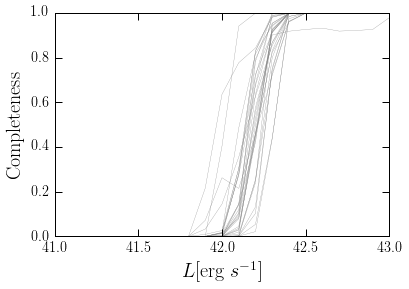

In [28]:
plt.figure('completeness')

for it in range(nbins):
    plt.plot(binarr, 10**comp_tile[it,:],'-',linewidth=0.25,color='gray')
    
plt.xlim([41,43] if groupby == 'lum_line' else [0.1,3])
plt.ylim([0,1])
xl = r'$L[{\rm erg}\ s^{-1}]$' if groupby == 'lum_line' else r'$\Delta m$'
plt.xlabel(xl,fontsize=20)
plt.ylabel(r'${\rm Completeness}$',fontsize=20)

plt.show()

In [20]:
# get f_snr file

snrfile = 'snr.data'
snrdata = pickle.load(open(snrfile)) 
marr = snrdata['marr']
frac_sn = snrdata['frac_sn']
alltiles0 = snrdata['alltiles']

# snrfunc is different for each tile
#snrfunc = interpolate.interp1d(marr,frac_sn, bounds_error=False, fill_value='extrapolate')



41.9235882537 43.4039084279
ntiles 484
306479333.537
full_circle [deg^2] 41252.9612494
frac_area: 0.0183965460179 area_survey [deg^2]: 2732083.2
Volume (Mpc^3): 306479333.537 306553480.536
[  9.78858824e-08   4.37758974e-07   1.40757645e-06   2.23500144e-06
   2.24450808e-06   1.69794311e-06   1.04462578e-06   6.22514537e-07
   3.37513147e-07   1.98472193e-07   1.38431542e-07   1.08216915e-07
   7.29598290e-08   4.61438475e-08   3.26286275e-08]
26204
26500


(array([   66.,   223.,   815.,   953.,  1694.,  1112.,  1501.,  1566.,
         2232.,  5590.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

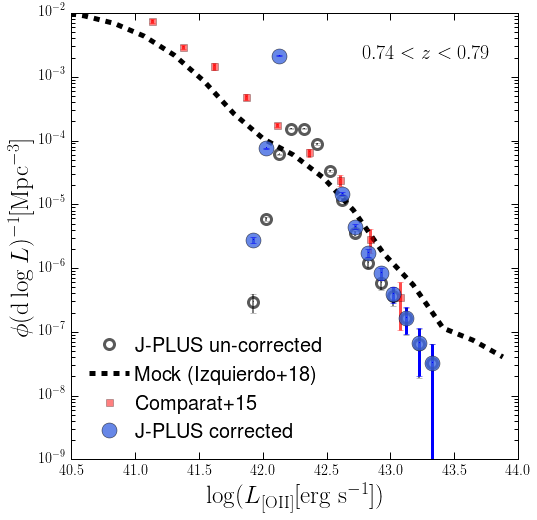

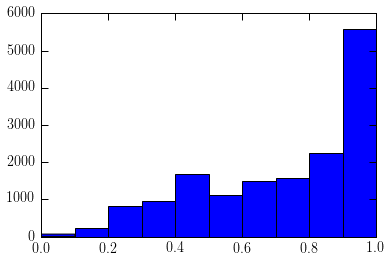

In [29]:
# Now compute that LF again using the completeness curves

%matplotlib inline
from astropy.cosmology import Planck15

ld= Planck15.luminosity_distance(0.75).value

#compute LFs
mpc2cm= 3.08e24
ld *= mpc2cm
id_oii = np.asarray(pred) == 'OII'

gal_oii = jplus.tools.select_object(dcat,id_oii)

f_oii = gal_oii['F_j0660']

loii = f_oii * 4*np.pi*ld**2

min_oii = np.min(np.log10(loii))
max_oii = np.max(np.log10(loii))
lbin = 0.1
nbins = int(np.floor((max_oii-min_oii)/lbin+1))
print min_oii,max_oii
binarr = np.arange(nbins)*lbin + min_oii

phi, lbb = np.histogram(np.log10(loii),bins=nbins,range=[min_oii-lbin/2.,max_oii+lbin/2.])

depth = Planck15.comoving_distance(0.8) - Planck15.comoving_distance(0.74)
area_tile = (1.4*60)**2 #deg^2
ntiles = len(np.unique(dcat['tile_id']))
print 'ntiles %d'%ntiles
mask_factor = 0.8 #to be computed properly
area_survey = area_tile*ntiles*mask_factor*(Planck15.kpc_comoving_per_arcmin(0.77).value/(1e3))**2
#volume = area_survey * depth.value
print volume

full_circle = 4*np.pi*(360.0/(2*np.pi))**2  #~41,000 deg^2
frac_area = 1.4**2 * ntiles*mask_factor / full_circle
print 'full_circle [deg^2]',full_circle
print 'frac_area:',frac_area, 'area_survey [deg^2]:',area_tile*ntiles*mask_factor
volume = (Planck15.comoving_volume(0.8).value - Planck15.comoving_volume(0.74).value)*frac_area 
volume_old = area_survey * depth.value
print 'Volume (Mpc^3):',volume, volume_old


errs =np.sqrt(phi)/(volume * lbin)
print errs

plt.figure('LFOII',figsize=(8,8))
ax = plt.subplot(111)

ax.semilogy(binarr, phi/volume/lbin,'ko',linewidth=2,markersize=10,label='J-PLUS un-corrected',
            alpha=.65,mfc='none',mew=3)
ax.errorbar(binarr, phi/volume/lbin, yerr = errs, fmt='k,',alpha=0.5,elinewidth=2)
ax.set_ylabel(r'$\phi ({\rm d}\log L)^{-1}[{\rm Mpc^{-3}]$',fontsize=25)
ax.set_xlabel(r'$\log(L_{\rm [OII]} [{\rm erg~s^{-1}}])$',fontsize=25)


fmockdata = 'data/z_0.7875'
fcomparatdata = 'data/z_0.7875_data'

mockphi = np.loadtxt(fmockdata)
dataphi = np.loadtxt(fcomparatdata)

ax.semilogy(mockphi[:,0],mockphi[:,1],'k--',linewidth=5,label='Mock (Izquierdo+18)')
ax.semilogy(dataphi[:,0],dataphi[:,1],'rs',markersize=7,label='Comparat+15',alpha=0.5)
ax.errorbar(dataphi[:,0],dataphi[:,1],yerr=[dataphi[:,5],dataphi[:,4]], fmt='r,',alpha=0.7,
            elinewidth=3)


#Now the corrected LF:

# Get the weights for each galaxy first
ntot = len(gal_oii['tile_id'])
gal_oii['weight_c'] = np.ones(ntot)
for it in range(ntiles):
    tt = alltiles[it]
    itt0 = np.where(tt == alltiles0)[0]
    #print itt0, len(marr), len(frac_sn[:,itt0])
    
    snrfunc = interpolate.interp1d(marr,frac_sn[:,itt0].squeeze(), bounds_error=False, fill_value='extrapolate')
    gsel = np.where(gal_oii['tile_id'] == tt)[0]
    ngal = len(gsel)
    if ngal == 0:
        print tt
        continue
    cf = comp_funcs[it][1]
    for ig in range(ngal):
        iid = gsel[ig]
        ll = np.log10(loii[iid]) if groupby == 'lum_line' else gal_oii['dm'][iid]
        ccf = cf(ll)
        gal_oii['weight_c'][iid] = (1./10**(ccf)) if ccf > -5 else -5 
        
        gal_oii['weight_c'][iid] *= 1./snrfunc(gal_oii['rSDSS'][iid,0])
       
        
 #       if ccf < -90:
 #           print ccf
  #      if it ==0:
  #          print it,ll, gal_oii['weight_c'][iid]
       # if ll < 42.0:
       #     print it,ll, gal_oii['weight_c'][iid]
    

phi2, lbb2 = np.histogram(np.log10(loii),bins=nbins,
                          range=[min_oii-lbin/2.,max_oii+lbin/2.],
                         weights = gal_oii['weight_c'])

errs2 =np.sqrt(phi2)/(volume * lbin)

ax.semilogy(binarr, phi2/volume/lbin,'o',linewidth=2,markersize=15,label='J-PLUS corrected',
            alpha=.8,color='RoyalBlue')
ax.errorbar(binarr, phi2/volume/lbin, yerr = errs2, fmt='b,',alpha=1.0,elinewidth=3)


ax.set_xlim([40.5,44])
ax.set_ylim([1e-9,1e-2])
ax.text(0.65,0.9,r'$0.74<z<0.79$',transform=ax.transAxes,fontsize=20)
ax.legend(loc='lower left',fontsize=20)


plt.figure('xx')

plt.hist(snrfunc(gal_oii['rSDSS'][:,0]))




In [7]:
import pymangle
generate_random_mask = False

if generate_random_mask:

    jpm_file = '/home/CEFCA/aaorsi/work/jplus_masks/jplus_dr1_masks.pol'
    print jpm_file
    jplus_mask = pymangle.mangle.Mangle(jpm_file)
    print 'creating randoms'
    jpran = jplus_mask.genrand(10000)
    ran_mask0 = {'coords':np.transpose([jpran[0], jpran[1]])}
else:    
    ranfile = 'random_mask.data'
    ran_mask0 = pickle.load(open(ranfile))

print ran_mask0.keys()
tiles = jplus.datasets.fetch_jplus_tile_list(db='dr1',overwrite=False)

print tiles.keys()


j-plus [INFO]: Fetching J-PLUS Tile list
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/objects_tile_list_dr1_dual.h5


['coords']
['ncombined', 'noise', 'min_ra', 'ADUlevel', 'tileIDs', 'texposed', 'min_dec', 'ref_tileID', 'filter', 'depth', 'effectime', 'max_dec', 'ra', 'SQL', 'date', 'max_ra', 'dec', 'fwhmg']


In [8]:
tile_scale = 1.5

def haversine_dist(ra1, dec1, ra2, dec2):
  th1 = np.pi/2. - dec1 * np.pi/180.0
  th2 = np.pi/2. - dec2 * np.pi/180.0

  ph1 = ra1 * np.pi/180.0
  ph2 = ra2 * np.pi/180.0

  dph = np.abs(ph1 - ph2)
  dth = np.abs(th1 - th2)

  harg = np.sin(dph/2)**2 + np.cos(ph1)*np.cos(ph2) * np.sin(dth/2.)**2

  return 2 *np.arcsin(np.sqrt(harg)) * 180./np.pi  # Return distance in degrees

#Get the mask tiles overlapping with ELGs
 
    
Load_rans=True
ranfile = 'ran_jplus'
if not Load_rans:
    print 'finding tile_id of random points...'
    nran = len(ran_mask0['coords'])
    print 'initial number of randoms %ld' % nran
    ran_tile_id = np.zeros(nran)

    m = []
    for i in range(nran):
        darr = haversine_dist(ran_mask0['coords'][i,0], ran_mask0['coords'][i,1], 
                              tiles['ra'], tiles['dec'])
        idt2 = np.argsort(darr)[0]  
        ran_tile_id[i] = tiles['ref_tileID'][idt2] 
        m.append(True if darr[idt2] < tile_scale else False)
        if i%10000 == 0:
            print float(i)/float(nran)

    randict = jplus.tools.select_object(ran_mask0, m)
    randict['tile_id'] = ran_tile_id[m]

    print 'Returning only random mask tiles with overlapping tiles with ELGs'

    unique_tiles = reduce(np.intersect1d, (np.unique(gal_oii['tile_id']), 
                                           np.unique(randict['tile_id'])))
    print 'number of intersecting tiles', len(unique_tiles)

    ran_mask   = jplus.tools.select_object(randict, 
                 np.array([item in unique_tiles for item in randict['tile_id']]))
    gal_oiin   = jplus.tools.select_object(gal_oii, 
                 np.array([item in unique_tiles for item in gal_oii['tile_id']]))
    
    print 'Final number of random points in mask:%ld'%len(ran_mask['tile_id'])
    overlap = {'ran':ran_mask, 'gal_oii':gal_oiin}
    with open(ranfile,'wb') as outfile:
        pickle.dump(overlap,outfile,protocol=pickle.HIGHEST_PROTOCOL)   
    
else:
    overlap = pickle.load(open(ranfile))

ran_mask = overlap['ran']
gal_oiin = overlap['gal_oii']



In [9]:
ran_mask.keys()
len(ran_mask['tile_id'])

472676

482
482
[26319 26319 26319 26319 26319 26319 26319 26319 26319 26319 26319 26319
 26319 26319 26319 26319 26319 26319 26319 26319 26319 26319 26319 26319
 26319 26319 26319 26319 26319 26319]
[ 164.1563  164.1563  164.1563  164.1563  164.1563  164.1563  164.1563
  164.1563  164.1563  164.1563  164.1563  164.1563] [ 79.1761  79.1761  79.1761  79.1761  79.1761  79.1761  79.1761  79.1761
  79.1761  79.1761  79.1761  79.1761]
[ 160.31573339  160.31573339  160.31573339  160.31573339  160.31573339
  160.31573339  160.31573339  160.31573339  160.31573339  160.31573339
  160.31573339  160.31573339] [ 168.33718111  168.33718111  168.33718111  168.33718111  168.33718111
  168.33718111  168.33718111  168.33718111  168.33718111  168.33718111
  168.33718111  168.33718111]
[ 78.43723665  78.43723665  78.43723665  78.43723665  78.43723665
  78.43723665  78.43723665  78.43723665  78.43723665  78.43723665
  78.43723665  78.43723665] [ 79.88809084  79.88809084  79.88809084  79.88809084  79.88809084
  79

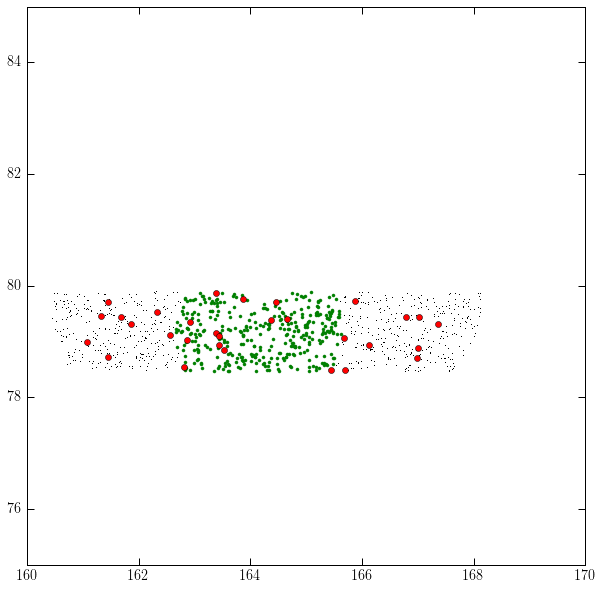

In [10]:
plt.figure(figsize=(10,10))

plt.plot(ran_mask0['coords'][:,0],ran_mask0['coords'][:,1],'k,')
plt.plot(ran_mask['coords'][:,0],ran_mask['coords'][:,1],'.',
         color='green')
plt.plot(gal_oiin['coords'][:,0],gal_oiin['coords'][:,1],'o',
         color='red')

xlim = [160,170]
ylim = [75,85]

plt.xlim(xlim)
plt.ylim(ylim)

print len(np.unique(ran_mask['tile_id']))
print len(np.unique(gal_oiin['tile_id']))

l1 = np.sort(np.unique(ran_mask['tile_id']))
l2 = np.sort(np.unique(gal_oiin['tile_id']))

sel0 =((ran_mask0['coords'][:,0] > xlim[0]) & 
       (ran_mask0['coords'][:,0] < xlim[1]) &
       (ran_mask0['coords'][:,1] > ylim[0]) &
       (ran_mask0['coords'][:,1] < ylim[1]))

sel = ((ran_mask['coords'][:,0] > xlim[0]) & 
       (ran_mask['coords'][:,0] < xlim[1]) &
       (ran_mask['coords'][:,1] > ylim[0]) &
       (ran_mask['coords'][:,1] < ylim[1]))

gsel = ((gal_oiin['coords'][:,0] > xlim[0]) & 
       (gal_oiin['coords'][:,0] < xlim[1]) &
       (gal_oiin['coords'][:,1] > ylim[0]) &
       (gal_oiin['coords'][:,1] < ylim[1]))

#print np.unique(randict['tile_id'][sel0])
ut = np.unique(ran_mask['tile_id'][sel])
print gal_oiin['tile_id'][gsel]
tt = np.where(tiles['ref_tileID'] == ut)
print tiles['ra'][tt], tiles['dec'][tt]
print tiles['min_ra'][tt], tiles['max_ra'][tt]
print tiles['min_dec'][tt], tiles['max_dec'][tt]



[26209 26209 26209]
26209
[False False False ..., False False False]


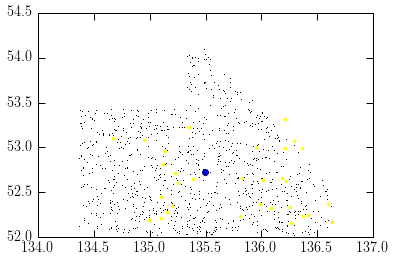

In [11]:
suspects = ((gal_oiin['coords'][:,0] > 135) & (gal_oiin['coords'][:,0] < 136) & 
            (gal_oiin['coords'][:,1] > 50) & (gal_oiin['coords'][:,1] <53 ))

stile =gal_oiin['tile_id'][suspects][0]
print gal_oiin['tile_id'][suspects]
print stile

ss = dcat['tile_id'] == stile
rr = ran_mask['tile_id'] == stile
tt = tiles['ref_tileID'] == stile
plt.figure('xxx')
plt.plot(ran_mask['coords'][rr,0],ran_mask['coords'][rr,1],'k,')
#plt.plot(ran_mask['coords'][:,0],ran_mask['coords'][:,1],',',color='green')


plt.plot(dcat['coords'][ss,0],dcat['coords'][ss,1],'.',color='yellow')
plt.plot([tiles['ra'][tt][0],tiles['ra'][tt][0]],
         [tiles['dec'][tt][0],tiles['dec'][tt][0]],'o')


print tt


In [12]:
print np.multiply(tiles['ra'][tt][0],[1,1])

[ 135.4943  135.4943]


nrandoms:472676


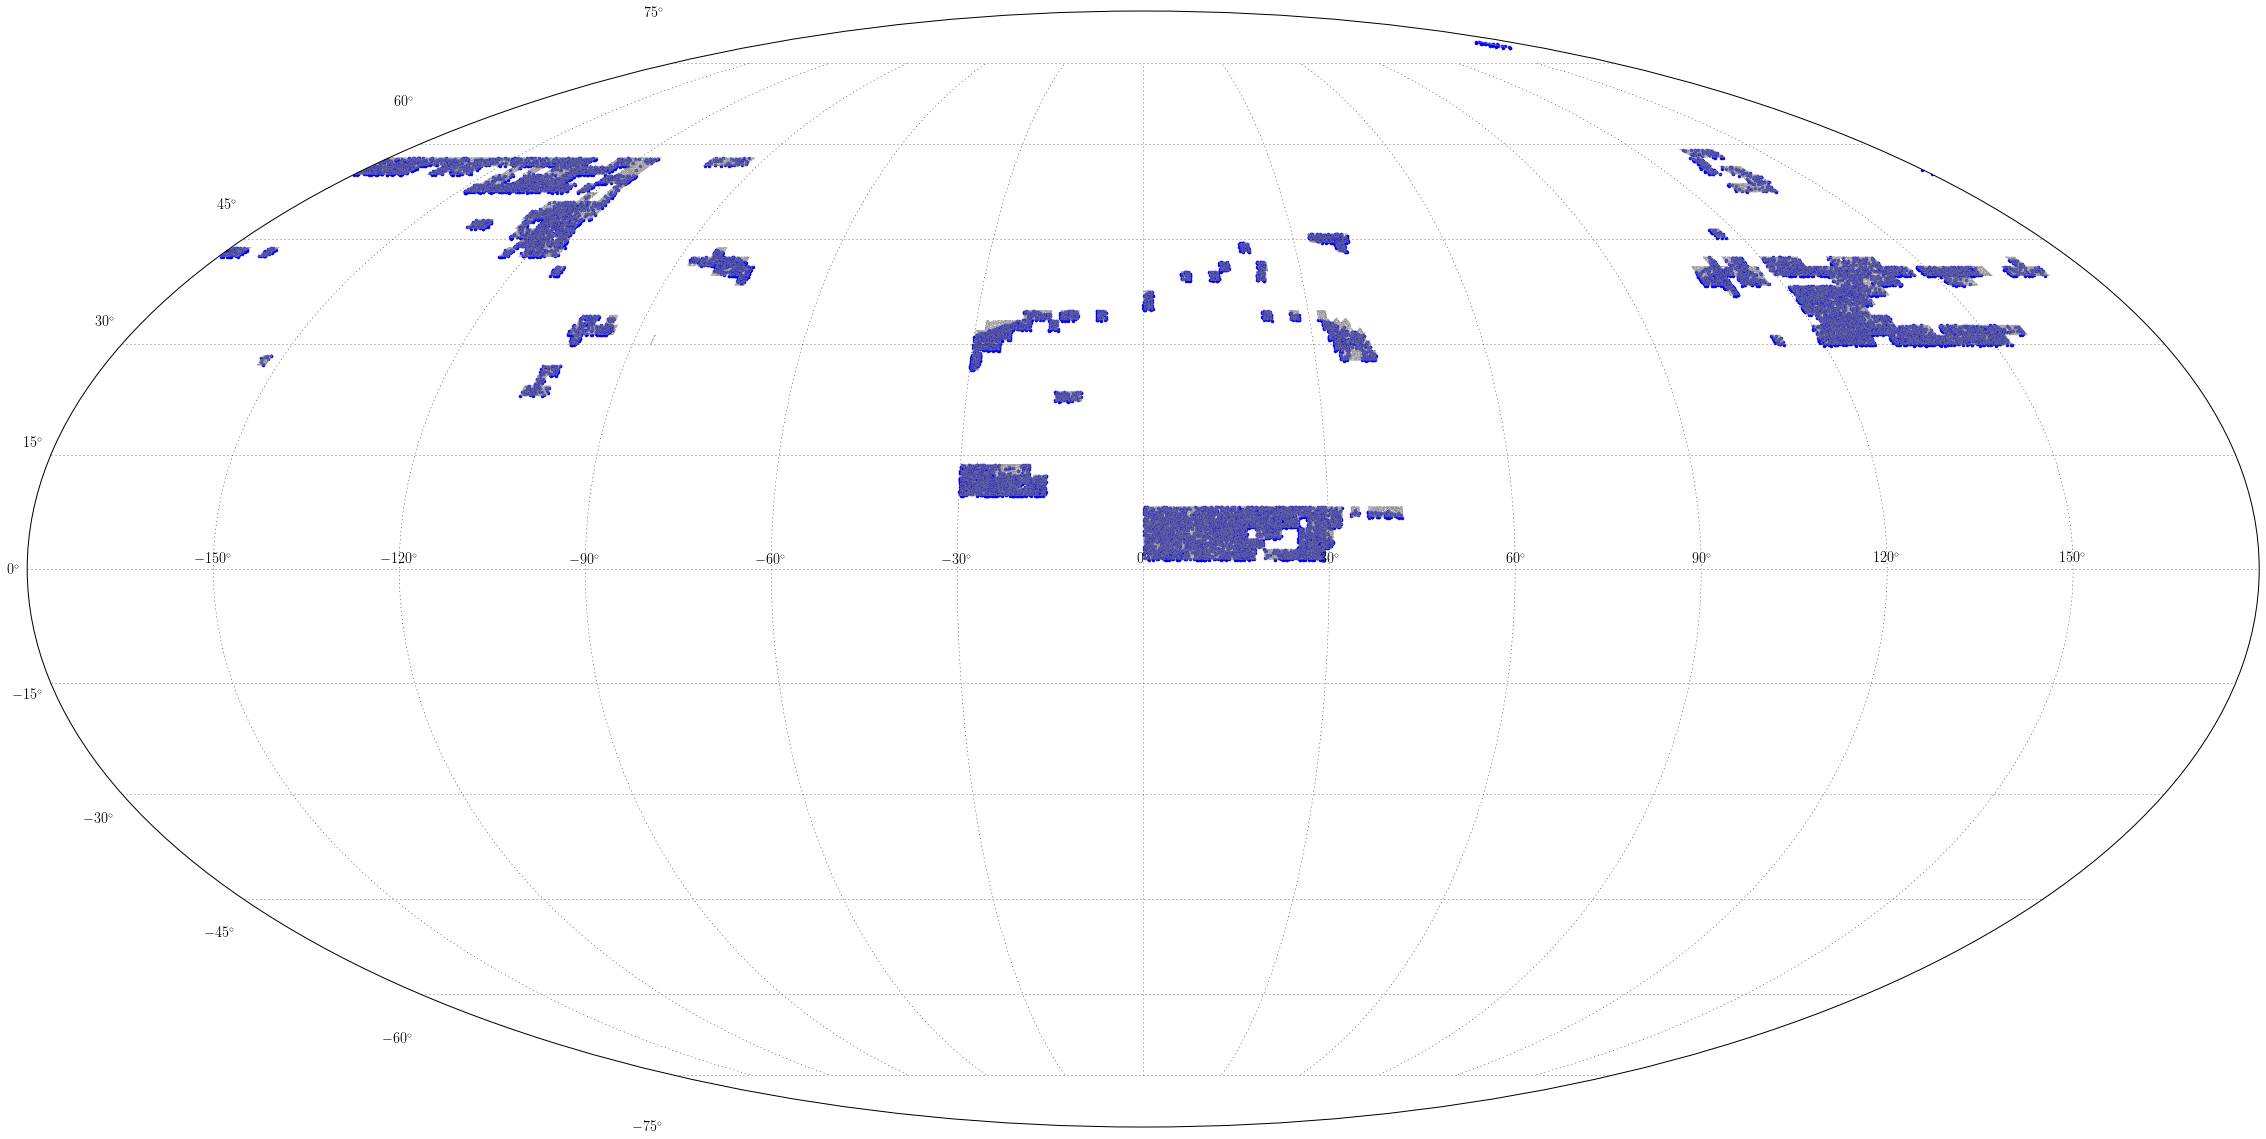

In [13]:
# Plot all objects in a world map!

import astropy.coordinates as coord
import astropy.units as u
plt.rcParams['figure.figsize'] = 40, 40

id_oii = np.asarray(pred) == 'OII'
id_oiii = np.asarray(pred) == 'OIII+Hbeta'
gal_oii = jplus.tools.select_object(dcat,id_oii)
gal_oiii = jplus.tools.select_object(dcat,id_oiii)
ran  = ran_mask

ljp = len(gal_oii['coords'])
#jpid = np.random.random_integers(0,ljp,int(ljp/1000))
jpid = np.arange(0,ljp)

ra = coord.Angle(gal_oii['coords'][jpid,0]*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(gal_oii['coords'][jpid,1]*u.degree)

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

ax.set_xlabel('',fontsize=80)
ax.set_ylabel('',fontsize=80)

ax.plot(ra.radian, dec.radian,'.', label='OII', alpha=1.0, color='blue')

#counts, ybins, xbins, image = plt.hist2d(ra.radian, dec.radian, bins=250, 
#                                         cmap=plt.cm.Greys, normed=LogNorm(), 
#                                         cmin=0.01, label='J-PLUS', alpha=0.8)

lw = len(ran['coords'])
print 'nrandoms:%ld' % lw
#wid = np.random.random_integers(0,lw,int(lw/100))
wid = np.arange(0,lw)
ra_2 = coord.Angle(ran['coords'][wid,0]*u.degree)
ra_2 = ra_2.wrap_at(180*u.degree)
dec_2 = coord.Angle(ran['coords'][wid,1]*u.degree)

#counts, ybins, xbins, image = plt.hist2d(ra_2.radian, dec_2.radian, bins=250, 
#                                         cmap=plt.cm.Blues, normed=LogNorm(), 
#                                         cmin=0.01, label='WiggleZ', alpha=0.8)

ax.plot(ra_2.radian, dec_2.radian,',',alpha=.1,color='gray', label='Random mask')
ax.grid(True)
ljp = len(gal_oiii['coords'])
#jpid = np.random.random_integers(0,ljp,int(ljp/1000))
jpid = np.arange(0,ljp)

ra = coord.Angle(gal_oiii['coords'][jpid,0]*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(gal_oiii['coords'][jpid,1]*u.degree)

#ax.set_xlabel('RA')
#ax.xaxis.label.set_fontsize(120)
#ax.set_ylabel('Dec')
#ax.yaxis.label.set_fontsize(10)

#ax.set_xlim([-20,20])
#ax.set_ylim([0,40])

#ax.plot(ra.radian, dec.radian,',', label='OIII', alpha=0.7, color='red')


#ax.legend(fontsize=60)

'\nplt.figure(5)\nrMin = 1.0\nrMax = 20.0\npiMin = 0.\npiMax = 0.\nproj_tpf = cbl.TwoPointCorrelation_projected(cat_objs, ran_objs,cbl.EnumTypes._linear_, rMin, rMax, nbins, shift, \n                                        angularUnits)\n\ncbl.set_ObjectRegion_SubBoxes(cat_objs,ran_objs,3,3,3)\nproj_tpf.measure(cbl.EnumTypes._Jackknife_,\'./\')\nproj_tpf.write(\'./\', \'test\')\n\nplt.errorbar(proj_tpf.xx(), proj_tpf.xi1D(), proj_tpf.error1D(), fmt=\'o\',color=\'royalblue\', label="2pt monopole")\nplt.legend()\nplt.xlabel(r\'$r_p$\',fontsize=20)\nplt.ylabel(r\'$w_p(r_p)$\',fontsize=20)\nplt.savefig(\'wp_rp.pdf\',bbox_inches=\'tight\')\n\n'

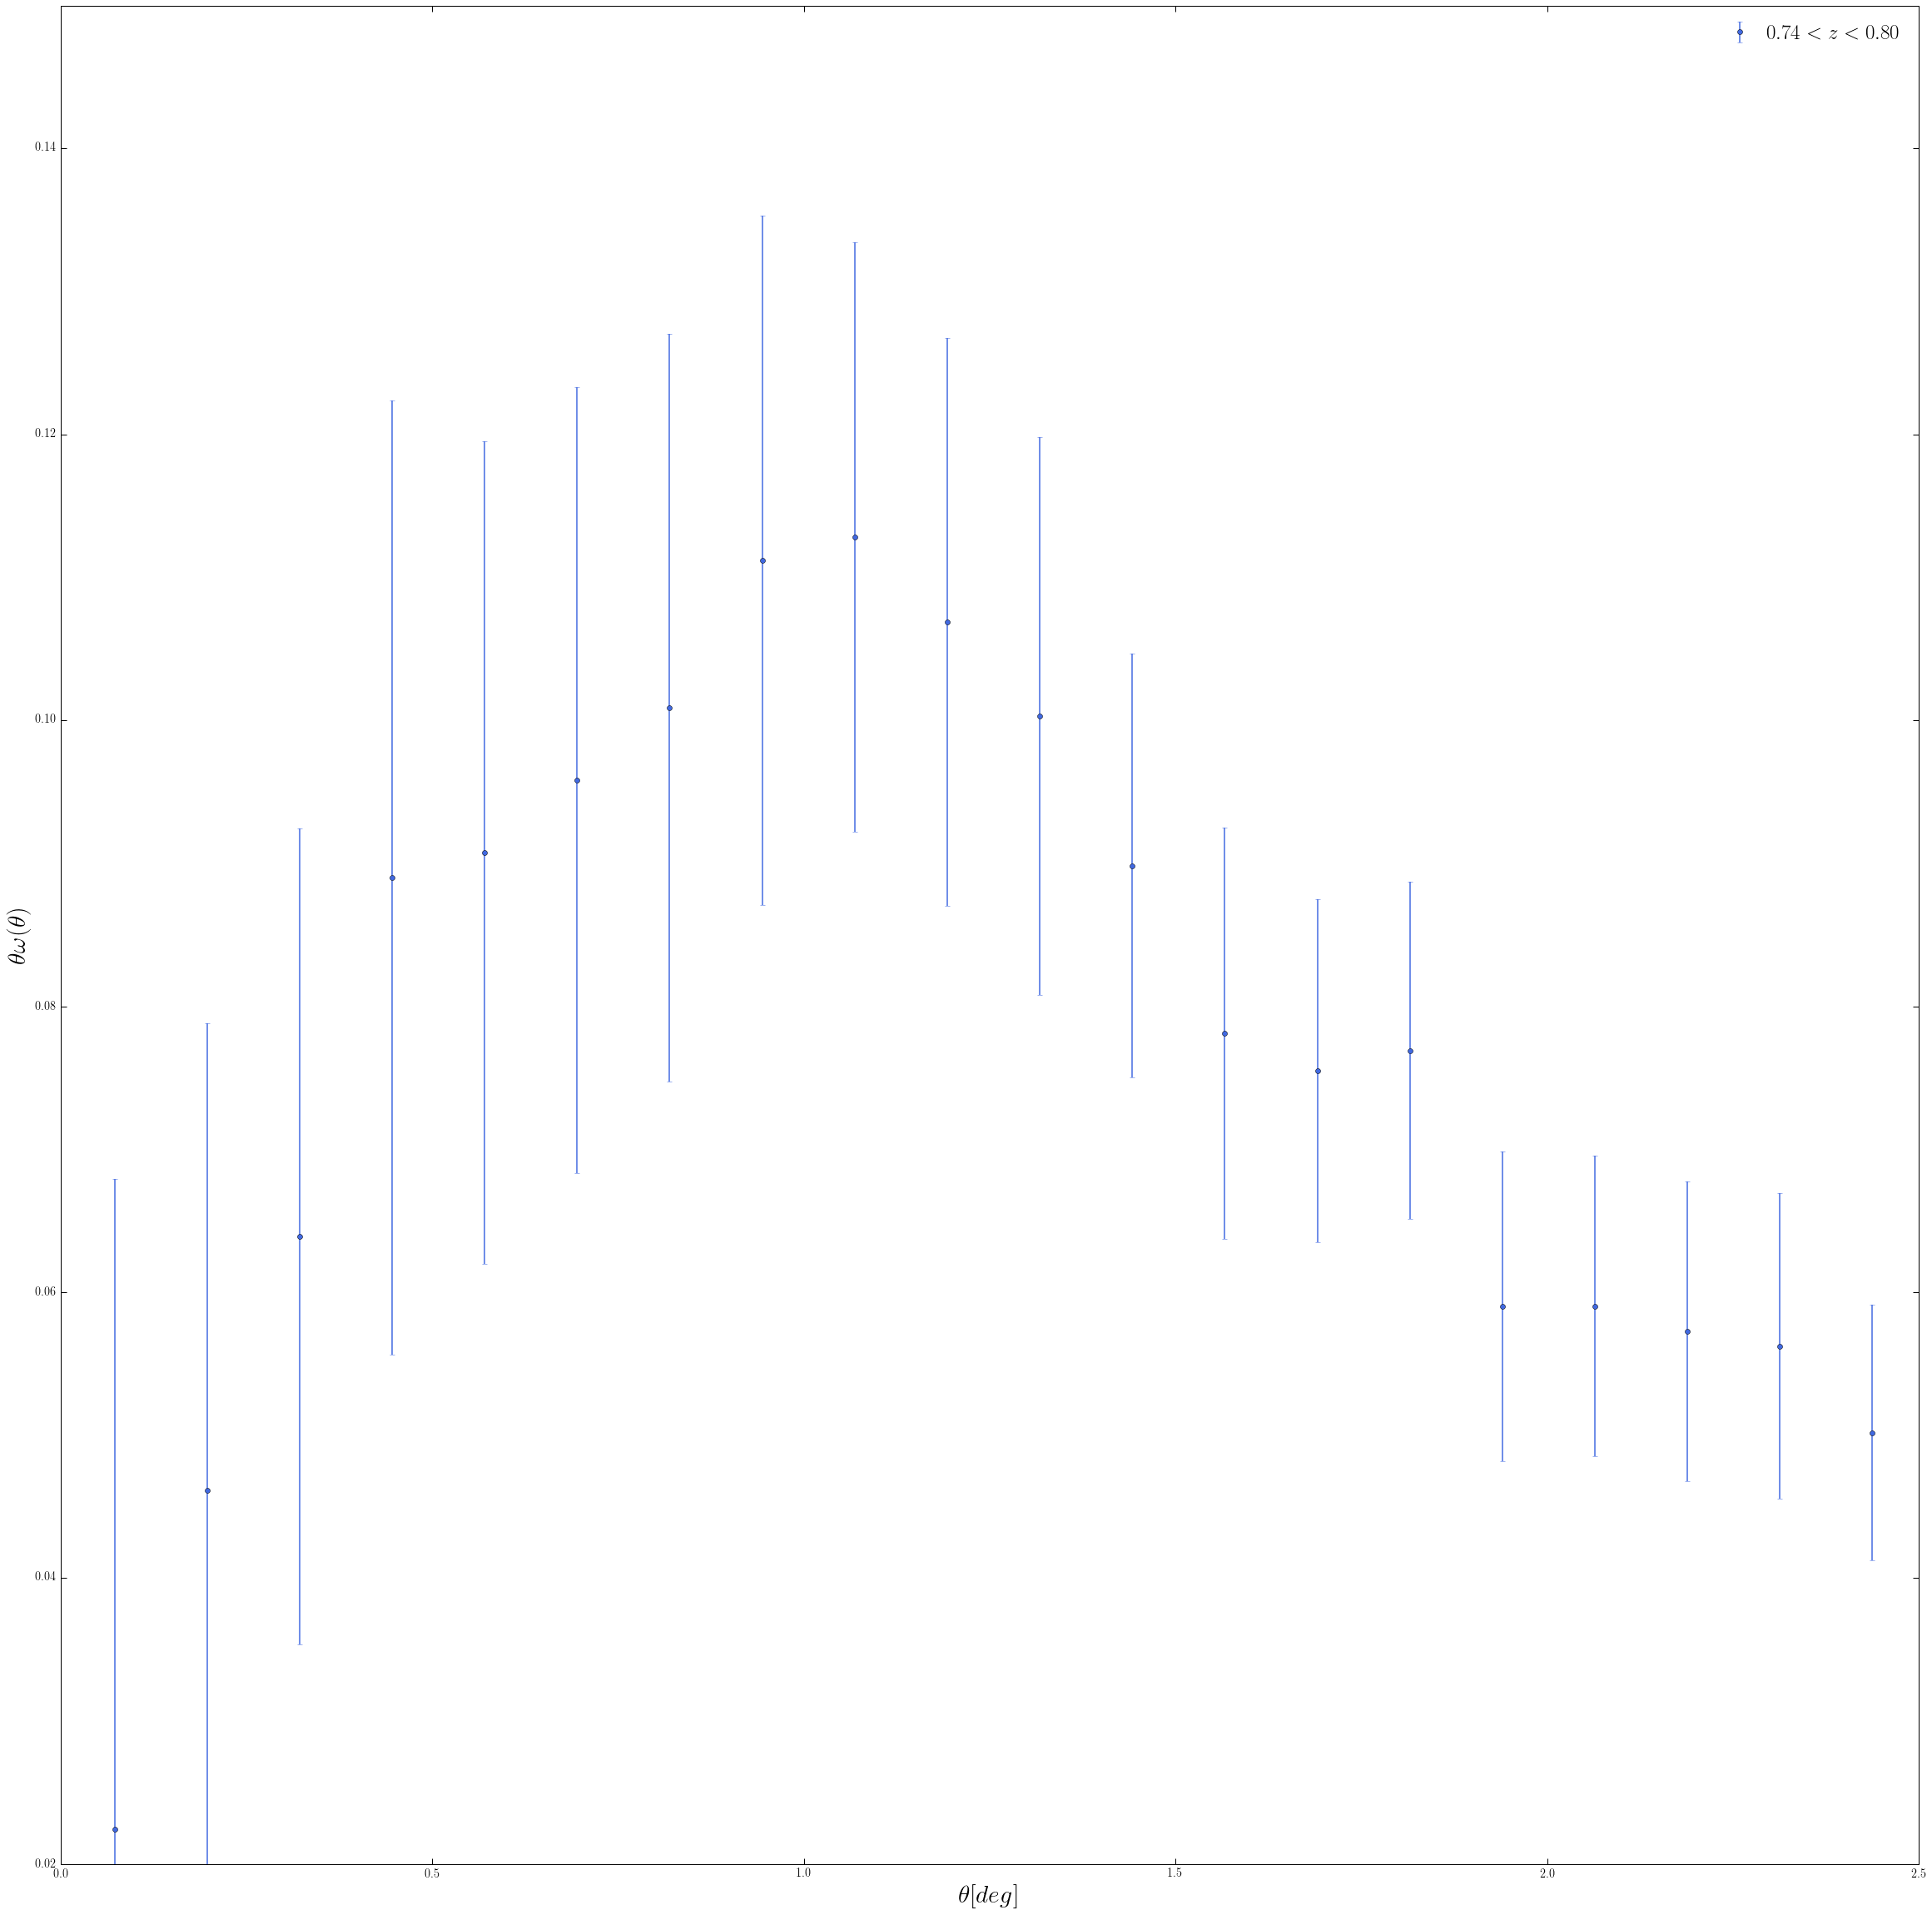

In [14]:
# Raw 2PCF:

readw = False

import CosmoBolognaLib as cbl
cosmology = cbl.Cosmology()

ran_mask['redshift'] = np.ones(len(ran_mask['coords']))
gal_oiin['redshift'] = np.ones(len(gal_oiin['coords']))

ra_mask = ran_mask['coords'][:,0].astype(float)
dec_mask = ran_mask['coords'][:,1].astype(float)

if readw is False:
    cat_objs = cbl.Catalogue(cbl.EnumTypes._Galaxy_, cbl.EnumTypes._observedCoordinates_, 
                            gal_oiin['coords'][:,0],gal_oiin['coords'][:,1],gal_oiin['redshift'], 
                             cosmology, cbl.EnumTypes._degrees_)

    ran_objs = cbl.Catalogue(cbl.EnumTypes._RandomObject_, cbl.EnumTypes._observedCoordinates_,
                            ra_mask,dec_mask, ran_mask['redshift'], cosmology, 
                             cbl.EnumTypes._degrees_)



    angMin = 0.01                #// minimum angular separation 
    angMax = 2.5                  #// maximum angular separation 
    nbins = 20                      #// number of bins
    shift = 0.5                  #// shift used to set the bin centre 
    angularUnits = cbl.EnumTypes._degrees_

    twopt = cbl.TwoPointCorrelation1D_angular(cat_objs, ran_objs,cbl.EnumTypes._linear_, angMin, angMax, nbins, shift, 
                                            angularUnits)
    cbl.set_ObjectRegion_SubBoxes(cat_objs,ran_objs,3,3,3)

    twopt.measure(cbl.EnumTypes._Jackknife_,'./')
    twopt.write('./', 'test');
    xx = np.asarray(twopt.xx())
    xi1D = np.asarray(twopt.xi1D())
    error1D = np.asarray(twopt.error1D())
else:
    xx, xi1D, error1D = np.loadtxt('test',unpack=True)
    
#plt.figure(4,figsize=(7,7))
fig,ax = plt.subplots(1)
ax.errorbar(xx, xx*xi1D, error1D, fmt='o',
             color='royalblue', label=r'$%.2f<z<%.2f$'%(0.74,0.8))
ax.legend(fontsize=25)
ax.set_ylim([0.02,0.15])
#plt.yscale('log')
#plt.xscale('log')

ax.set_xlabel(r'$\theta [deg]$',fontsize=30)
ax.set_ylabel(r'$\theta\omega(\theta)$',fontsize=30)
plt.savefig('w_elgcand.pdf',bbox_inches='tight')

"""
plt.figure(5)
rMin = 1.0
rMax = 20.0
piMin = 0.
piMax = 0.
proj_tpf = cbl.TwoPointCorrelation_projected(cat_objs, ran_objs,cbl.EnumTypes._linear_, rMin, rMax, nbins, shift, 
                                        angularUnits)

cbl.set_ObjectRegion_SubBoxes(cat_objs,ran_objs,3,3,3)
proj_tpf.measure(cbl.EnumTypes._Jackknife_,'./')
proj_tpf.write('./', 'test')

plt.errorbar(proj_tpf.xx(), proj_tpf.xi1D(), proj_tpf.error1D(), fmt='o',color='royalblue', label="2pt monopole")
plt.legend()
plt.xlabel(r'$r_p$',fontsize=20)
plt.ylabel(r'$w_p(r_p)$',fontsize=20)
plt.savefig('wp_rp.pdf',bbox_inches='tight')

"""

['flags_aper3_gauss_uJAVA', 'flags_aper3_gauss_J0378', 'dm_j0660', 'J0861', 'flags_aper3_worstpsf_J0378', 'fwhm', 'cstar', 'flags_aper3_worstpsf_J0515', 'mag_auto_r', 'mask_flags_J0515', 'single_detect_J0395', 'uJAVA', 'dm', 'F_j0660', 'single_detect_zJAVA', 'flags_aper3_gauss_J0515', 'gJAVA', 'norm_wmap_val_J0378', 'J0378', 'norm_wmap_val_rJAVA', 'single_detect_J0515', 'flags_aper3_gauss_iJAVA', 'flag_J0430', 'flags_aper3_gauss_zJAVA', 'flag_uJAVA', 'flags_aper3_worstpsf_J0861', 'elgcand', 'mask_flags_J0660', 'J0515', 'flags_aper3_worstpsf_J0410', 'mask_flags_gJAVA', 'flags_aper3_worstpsf_J0430', 'filename', 'single_detect_gJAVA', 'norm_wmap_val_iJAVA', 'flags_aper3_gauss_J0660', 'single_detect_uJAVA', 'F_cont_j0660', 'err_dm', 'mask_flags_uJAVA', 'norm_wmap_val_J0515', 'flags_aper3_gauss_J0861', 'zSDSS', 'kron_rad', 'XY_IMAGE', 'mask_flags_J0378', 'flag_J0410', 'ids', 'dm_j0660_err', 'single_detect_J0430', 'flags_aper3_worstpsf_J0395', 'rJAVA', 'flag_J0395', 'mask_flags_iJAVA', 'sing

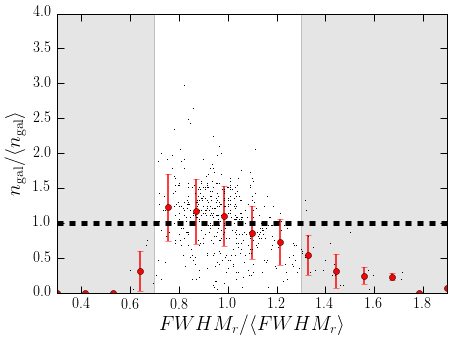

In [15]:
#Checking systematics
print gal_oii.keys()
tile, mag, total = jplus.plotting.groupbytile(gal_oiin['tile_id'], gal_oiin['J0660'][:,0])
#plt.figure()
#plt.plot(tile, mag,'o')
#print tile, total

n_avg = np.mean(total)
n_navg = total/n_avg
tile_oii, fwhm, total = jplus.plotting.groupbytile(gal_oiin['tile_id'], gal_oiin['fwhm'])

#print tiles.keys()
#plt.figure()
#plt.plot(n_navg, fwhm,'.')


def med_property(xprop,yprop,nbins,prange):
    xarr = np.linspace(prange[0],prange[1],nbins)
    yarr= np.zeros(nbins)
    pp = np.zeros(nbins)
    bs = xarr[1]-xarr[0]
    for i in range(nbins):
        ss = np.where((xprop >xarr[i] - bs/2.) & (xprop < xarr[i]+bs/2.))[0]
        if len(ss) == 0:
            continue
        yarr[i] = np.median(yprop[ss])
        pp[i] = np.std(yprop[ss])
        
    
    return xarr,yarr,pp

        
nbins= 15
prange = [0.3,1.9]

def plot_syst(f_favg, n_navg,nbins=15,prange=[0.65,1.5],
              xlabel=r'$FWHM_r/\langle FWHM_r \rangle$',
             ylabel=r'$n_{\rm gal}/\langle n_{\rm gal}\rangle$'):

    plt.figure(figsize=(7,5))
    plt.plot(f_favg, n_navg,',',color='black')
    plt.xlabel(xlabel,fontsize=20)
    plt.ylabel(ylabel,fontsize=20)
    plt.xlim(prange)
    plt.plot(prange,[1,1],'--',linewidth=5,color='black')
    xp,yp,pp = med_property(f_favg, n_navg,nbins, prange)
    #plt.plot(xp,yp,'o')
    plt.errorbar(xp,yp,yerr=pp,fmt='o',color='red')
    
    return xp,yp,pp

avg_fwhm = np.mean(fwhm)
f_favg  = fwhm / avg_fwhm

xp,yp,pp = plot_syst(f_favg, n_navg,prange=prange)

plt.fill_between([xp[0],0.7],[0,0],[4,4],facecolor='gray',alpha=0.2)
plt.fill_between([1.3,3],[0,0],[4,4],facecolor='gray',alpha=0.2)

gal_oiin['d_fwhm'] = gal_oiin['fwhm']/avg_fwhm
print 'len = %d'%len(gal_oiin['d_fwhm'])

sel = ((gal_oiin['d_fwhm'] >0.7) &
       (gal_oiin['d_fwhm'] <1.2))

print len(gal_oiin['d_fwhm'])
print 'Number of galaxies before FWHM sel:%d'%len(gal_oiin['tile_id'])
gal_oiin_fwhm = jplus.tools.select_object(gal_oiin, sel)
print 'Number of galaxies:%d'%len(gal_oiin_fwhm['tile_id'])







['ncombined', 'noise', 'min_ra', 'ADUlevel', 'tileIDs', 'texposed', 'min_dec', 'ref_tileID', 'filter', 'depth', 'effectime', 'max_dec', 'ra', 'SQL', 'date', 'max_ra', 'dec', 'fwhmg']
[ 1.55741516  0.82451391  1.07821049  0.48333574  0.73772297  1.55741516
  0.48333574  0.82451391  0.87604603  0.48333574  0.73772297  0.56066946
  0.56066946  0.56066946  3.5041841   0.82451391  0.82451391  0.50059773
  0.50059773  0.50059773  0.50059773  0.50059773  0.70083682  0.70083682
  0.93444909  0.93444909  1.00119546  0.82451391  1.07821049  0.63712438
  0.70083682  1.07821049  1.16806137  0.50059773  0.50059773  0.66746364
  0.66746364  0.56066946  0.87604603  1.55741516  0.50059773  0.77870758
  0.58403068  1.75209205  0.77870758  0.77870758  3.5041841   0.77870758
  0.77870758  0.87604603  0.87604603  0.87604603  1.07821049  0.56066946
  0.77870758  1.16806137  0.77870758  0.53910525  1.16806137  1.16806137
  0.82451391  0.82451391  2.33612273  1.16806137  0.73772297  0.73772297
  1.07821049  

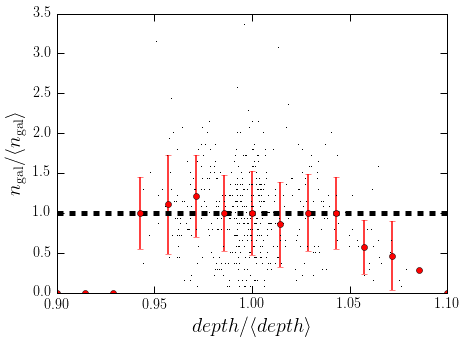

In [21]:
# get properties from tiles

print tiles.keys()


oii_tiles= np.unique(gal_oiin_fwhm['tile_id'])
gal_oiin_fwhm['depth'] = np.zeros(len(gal_oiin_fwhm['tile_id']))

for tt in oii_tiles:
    id_oii = np.where(np.asarray(gal_oiin_fwhm['tile_id']) == tt)[0]
    id_tarr = np.where(np.asarray(tiles['ref_tileID']) == tt)[0]
    gal_oiin_fwhm['depth'][id_oii] = tiles['depth'][id_tarr][5]
   
    #    print tiles['depth'][id_tarr]
#    print 'Ngals tile and depth %d:%d'%(tt,len(id_oii))



tile_oii, depth_tiles, total = jplus.plotting.groupbytile(gal_oiin_fwhm['tile_id'], 
                                                          gal_oiin_fwhm['depth'])


#tile, mag, total = jplus.plotting.groupbytile(gal_oiin_fwhm['tile_id'], gal_oiin_fwhm['J0660'][:,0])
#plt.figure()
#plt.plot(tile, mag,'o')
#print tile, total

n_avg = np.mean(total)
n_navg = total/n_avg


avg_depth = np.mean(depth_tiles)
f_favg    = depth_tiles / avg_depth
xp,yp,pp  = plot_syst(f_favg, n_navg, 
            xlabel=r'$depth/\langle depth\rangle$',
            prange=[0.9,1.1])

gal_oiin_fwhm['weight'] =  np.zeros(len(gal_oiin_fwhm['tile_id']))
for tt in oii_tiles:
    id_oii = np.where(np.asarray(gal_oiin_fwhm['tile_id']) == tt)[0]
    id_tarr = np.where(np.asarray(tile_oii) == tt)[0]
    gal_oiin_fwhm['weight'][id_oii] = 1./n_navg[id_tarr]
    

print gal_oiin_fwhm['weight'][0:100]



#gal_oiin['d_davg'] = f_favg
from scipy import interpolate

xpr = [.95,1.05]

dn = interpolate.interp1d(xp,yp, bounds_error=False, fill_value=1e-2)

ww = gal_oiin_fwhm['depth']/avg_depth
wws = (gal_oiin_fwhm['weight'] > 0) & (gal_oiin_fwhm['weight'] < 5)

gal_oii_clean = jplus.tools.select_object(gal_oiin_fwhm, wws)
print 'Number of objects of clean sample: ', len(gal_oii_clean['tile_id'])

unique_tiles = reduce(np.intersect1d, (np.unique(gal_oii_clean['tile_id']), 
                                           np.unique(ran_mask['tile_id'])))
print 'number of intersecting tiles', len(unique_tiles)

ran_mask_clean   = jplus.tools.select_object(ran_mask, 
             np.array([item in unique_tiles for item in ran_mask['tile_id']]))





6662
0.298228434078 4.67224546722


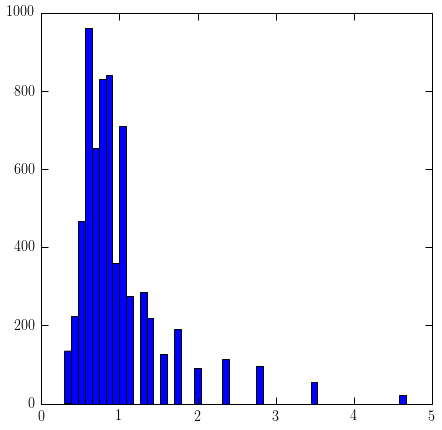

In [26]:
#gal_oii_clean['weight'] = 1./(gal_oii_clean['depth']/avg_depth)

plt.figure(figsize=(7,7))
plt.hist(gal_oii_clean['weight'],bins=50)
print len(gal_oii_clean['weight'])

print gal_oii_clean['weight'].min(), gal_oii_clean['weight'].max()
gal_oii_clean['weight'] = np.ones(len(gal_oii_clean['tile_id']))

[ 0.12225  0.34675  0.57125  0.79575  1.02025  1.24475  1.46925  1.69375
  1.91825  2.14275  2.36725  2.59175  2.81625  3.04075  3.26525  3.48975
  3.71425  3.93875  4.16325  4.38775] [ 0.23296975  0.17593711  0.13631771  0.09084125  0.09668562  0.06940738
  0.04672388  0.03421485  0.02474613  0.02059078  0.01136256  0.02085107
  0.02216556  0.0324197   0.02846677  0.02048684  0.02046697  0.02490435
  0.02580955  0.02450472]
7


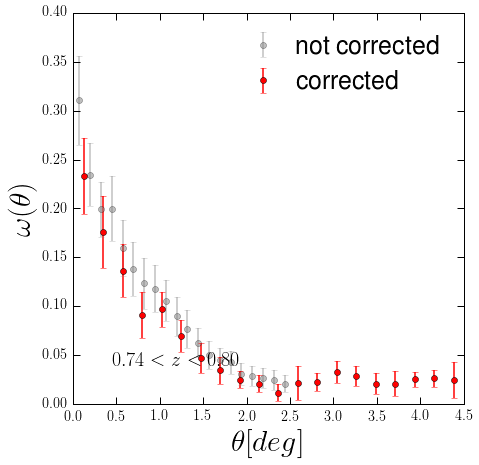

In [27]:
# Weighted 2pt

readw = False
if readw is False:
    
    #cbl.EnumTypes._Weight_ = gal_oii['weight']
    #cat_objs = cbl.Catalogue(cbl.EnumTypes._Galaxy_, cbl.EnumTypes._observedCoordinates_, 
    #                        gal_oii['coords'][:,0],gal_oii['coords'][:,1],gal_oii['redshift'], cbl.EnumTypes._Weight_,
    #                         cosmology, cbl.EnumTypes._degrees_)
    
    cat_objs = cbl.Catalogue(cbl.EnumTypes._Galaxy_, cbl.EnumTypes._observedCoordinates_, 
                             gal_oii_clean['coords'][:,0],gal_oii_clean['coords'][:,1],gal_oii_clean['redshift'], 
                             gal_oii_clean['weight'], cosmology, cbl.EnumTypes._degrees_)


    
    ran_objs = cbl.Catalogue(cbl.EnumTypes._RandomObject_, cbl.EnumTypes._observedCoordinates_,
                            ran_mask_clean['coords'][:,0].astype(float),
                             ran_mask_clean['coords'][:,1].astype(float),ran_mask_clean['redshift'],cosmology, 
                            cbl.EnumTypes._degrees_)

    

    angMin = 0.01                #// minimum angular separation 
    angMax = 4.5                  #// maximum angular separation 
    nbins = 20                      #// number of bins
    shift = 0.5                  #// shift used to set the bin centre 
    angularUnits = cbl.EnumTypes._degrees_

    twopt = cbl.TwoPointCorrelation1D_angular(cat_objs, ran_objs,cbl.EnumTypes._linear_, 
                                              angMin, angMax, nbins, shift, angularUnits)
    cbl.set_ObjectRegion_SubBoxes(cat_objs,ran_objs,3,3,3)

    twopt.measure(cbl.EnumTypes._Jackknife_,'./')
    twopt.write('./', 'test2');
    xxc = np.asarray(twopt.xx())
    xi1Dc = np.asarray(twopt.xi1D())
    error1Dc = np.asarray(twopt.error1D())
else:
    xxc, xi1Dc, error1Dc = np.loadtxt('test2',unpack=True)


fig,ax = plt.subplots(1,figsize=(7,7))
ax.errorbar(xx, xi1D, error1D, fmt='o',
             color='gray', label='not corrected',alpha=0.5)
ax.errorbar(xxc, xi1Dc, error1Dc, fmt='o',
             color='red', label='corrected')
ax.text(0.1,.10,r'$%.2f<z<%.2f$'%(0.74,0.8),transform=ax.transAxes,fontsize=20)
ax.legend(fontsize=25)
#ax.set_ylim([0.02,0.15])
#plt.yscale('log')
#plt.xscale('log')

ax.set_xlabel(r'$\theta [deg]$',fontsize=30)
ax.set_ylabel(r'$\omega(\theta)$',fontsize=30)
plt.savefig('w_elgcand.pdf',bbox_inches='tight')

print xxc, xi1Dc
print cbl.EnumTypes._Weight_

In [19]:
#Files for Marulli

gals = 'gals.data'
rans = 'rans.data'

fd = open(gals,'w')

print len(gal_oiin['tile_id'])

for i in range(len(gal_oiin['tile_id'])):
    fd.write('%.3f %.3f %.3f\n' % (gal_oiin['coords'][i,0], 
                                  gal_oiin['coords'][i,1],
                                  gal_oiin['weight'][i]))


fd.close()



ff = open(rans,'w')
for i in range(len(ran_mask['tile_id'])):
    ff.write('%.3f %.3f \n' % (ran_mask['coords'][i,0], 
                                  ran_mask['coords'][i,1],
                                  ))

ff.close()


15752


KeyError: 'weight'

In [ ]:
%matplotlib inline
plt.figure('xx',figsize=(10,10))


plt.plot(ran_mask['coords'][:,0],ran_mask['coords'][:,1],'k,')
plt.plot(gal_oiin['coords'][:,0],gal_oiin['coords'][:,1],',',color='yellow')
plt.xlim([180,220])
plt.ylim([20,60])